# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=1,
        fold=3,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_10-29-38/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4793 | MulticlassF1Score=0.1023
Batch-30 : CrossEntropyLoss=2.4617 | MulticlassF1Score=0.1816
Batch-45 : CrossEntropyLoss=2.4631 | MulticlassF1Score=0.2298
Batch-60 : CrossEntropyLoss=2.4547 | MulticlassF1Score=0.2646
Batch-75 : CrossEntropyLoss=2.4442 | MulticlassF1Score=0.2873
Batch-90 : CrossEntropyLoss=2.4432 | MulticlassF1Score=0.3032
Batch-105: CrossEntropyLoss=2.4381 | MulticlassF1Score=0.3123
Batch-120: CrossEntropyLoss=2.4394 | MulticlassF1Score=0.3218
Batch-135: CrossEntropyLoss=2.3994 | MulticlassF1Score=0.3324
Batch-150: CrossEntropyLoss=2.3696 | MulticlassF1Score=0.3586
Batch-165: CrossEntropyLoss=2.3619 | MulticlassF1Score=0.3854
Batch-180: CrossEntropyLoss=2.3594 | MulticlassF1Score=0.4090
Batch-195: CrossEntropyLoss=2.3348 | MulticlassF1Score=0.4288
Batch-210: CrossEntropyLoss=2.3528 | MulticlassF1Score=0.4467
Batch-225: CrossEntropyLoss=2.3260 | MulticlassF1Score=0.4615
Batch-226: CrossEntropyLoss=2.3418 | MulticlassF1Score=0.4621

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3691 | MulticlassF1Score=0.6833
Batch-30 : CrossEntropyLoss=2.3402 | MulticlassF1Score=0.6798
Batch-45 : CrossEntropyLoss=2.3566 | MulticlassF1Score=0.6773
Batch-60 : CrossEntropyLoss=2.3664 | MulticlassF1Score=0.6784
Batch-63 : CrossEntropyLoss=2.3314 | MulticlassF1Score=0.6783

Training   : Mean CrossEntropyLoss = 2.4241 | Mean MulticlassF1Score = 0.3080
Validation : Mean CrossEntropyLoss = 2.3478 | Mean MulticlassF1Score = 0.6806

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3544 | MulticlassF1Score=0.6819
Batch-30 : CrossEntropyLoss=2.3536 | MulticlassF1Score=0.6754
Batch-45 : CrossEntropyLoss=2.3399 | MulticlassF1Score=0.6769
Batch-60 : CrossEntropyLoss=2.3543 | MulticlassF1Score=0.6781
Batch-75 : CrossEntropyLoss=2.3522 | MulticlassF1Score=0.6782
Batch-90 : CrossEntropyLoss=2.3591 | MulticlassF1Score=0.6800
Batch-105: CrossEntropyLoss=2.3417 | MulticlassF1Score=0.6794
Batch-120: CrossEntropyLoss=2.3342 | MulticlassF1Score=0.6788
Batch-135: CrossEntropyLoss=2.3501 | MulticlassF1Score=0.6821
Batch-150: CrossEntropyLoss=2.3338 | MulticlassF1Score=0.6852
Batch-165: CrossEntropyLoss=2.3346 | MulticlassF1Score=0.6891
Batch-180: CrossEntropyLoss=2.3251 | MulticlassF1Score=0.6912
Batch-195: CrossEntropyLoss=2.3272 | MulticlassF1Score=0.6937
Batch-210: CrossEntropyLoss=2.3327 | MulticlassF1Score=0.6959
Batch-225: CrossEntropyLoss=2.3374 | MulticlassF1Score=0.6981
Batch-226: CrossEntropyLoss=2.3334 | MulticlassF1Score=0.6981

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3329 | MulticlassF1Score=0.7238
Batch-30 : CrossEntropyLoss=2.3357 | MulticlassF1Score=0.7292
Batch-45 : CrossEntropyLoss=2.3230 | MulticlassF1Score=0.7269
Batch-60 : CrossEntropyLoss=2.3170 | MulticlassF1Score=0.7271
Batch-63 : CrossEntropyLoss=2.3365 | MulticlassF1Score=0.7263

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3420 | Mean MulticlassF1Score = 0.6834
Validation : Mean CrossEntropyLoss = 2.3330 | Mean MulticlassF1Score = 0.7268

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3288 | MulticlassF1Score=0.7227
Batch-30 : CrossEntropyLoss=2.3244 | MulticlassF1Score=0.7267
Batch-45 : CrossEntropyLoss=2.3254 | MulticlassF1Score=0.7308
Batch-60 : CrossEntropyLoss=2.3270 | MulticlassF1Score=0.7304
Batch-75 : CrossEntropyLoss=2.3385 | MulticlassF1Score=0.7287
Batch-90 : CrossEntropyLoss=2.3419 | MulticlassF1Score=0.7287
Batch-105: CrossEntropyLoss=2.3347 | MulticlassF1Score=0.7287
Batch-120: CrossEntropyLoss=2.3411 | MulticlassF1Score=0.7281
Batch-135: CrossEntropyLoss=2.3101 | MulticlassF1Score=0.7281
Batch-150: CrossEntropyLoss=2.3283 | MulticlassF1Score=0.7281
Batch-165: CrossEntropyLoss=2.3243 | MulticlassF1Score=0.7276
Batch-180: CrossEntropyLoss=2.3379 | MulticlassF1Score=0.7266
Batch-195: CrossEntropyLoss=2.3339 | MulticlassF1Score=0.7269
Batch-210: CrossEntropyLoss=2.3347 | MulticlassF1Score=0.7271
Batch-225: CrossEntropyLoss=2.3210 | MulticlassF1Score=0.7296
Batch-226: CrossEntropyLoss=2.3208 | MulticlassF1Score=0.7296

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3268 | MulticlassF1Score=0.7644
Batch-30 : CrossEntropyLoss=2.3146 | MulticlassF1Score=0.7686
Batch-45 : CrossEntropyLoss=2.3156 | MulticlassF1Score=0.7700
Batch-60 : CrossEntropyLoss=2.3137 | MulticlassF1Score=0.7704
Batch-63 : CrossEntropyLoss=2.3252 | MulticlassF1Score=0.7706

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3319 | Mean MulticlassF1Score = 0.7281
Validation : Mean CrossEntropyLoss = 2.3196 | Mean MulticlassF1Score = 0.7655

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.7829
Batch-30 : CrossEntropyLoss=2.3134 | MulticlassF1Score=0.7855
Batch-45 : CrossEntropyLoss=2.3229 | MulticlassF1Score=0.7876
Batch-60 : CrossEntropyLoss=2.3172 | MulticlassF1Score=0.7888
Batch-75 : CrossEntropyLoss=2.3191 | MulticlassF1Score=0.7902
Batch-90 : CrossEntropyLoss=2.3144 | MulticlassF1Score=0.7901
Batch-105: CrossEntropyLoss=2.3120 | MulticlassF1Score=0.7906
Batch-120: CrossEntropyLoss=2.3169 | MulticlassF1Score=0.7913
Batch-135: CrossEntropyLoss=2.3071 | MulticlassF1Score=0.7930
Batch-150: CrossEntropyLoss=2.3169 | MulticlassF1Score=0.7938
Batch-165: CrossEntropyLoss=2.3108 | MulticlassF1Score=0.7950
Batch-180: CrossEntropyLoss=2.3078 | MulticlassF1Score=0.7953
Batch-195: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.7962
Batch-210: CrossEntropyLoss=2.3087 | MulticlassF1Score=0.7968
Batch-225: CrossEntropyLoss=2.3041 | MulticlassF1Score=0.7980
Batch-226: CrossEntropyLoss=2.3064 | MulticlassF1Score=0.7980

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8098
Batch-30 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8075
Batch-45 : CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8100
Batch-60 : CrossEntropyLoss=2.3183 | MulticlassF1Score=0.8083
Batch-63 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8080

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3108 | Mean MulticlassF1Score = 0.7916
Validation : Mean CrossEntropyLoss = 2.3073 | Mean MulticlassF1Score = 0.8092

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3110 | MulticlassF1Score=0.8144
Batch-30 : CrossEntropyLoss=2.3090 | MulticlassF1Score=0.8129
Batch-45 : CrossEntropyLoss=2.3082 | MulticlassF1Score=0.8121
Batch-60 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8099
Batch-75 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8106
Batch-90 : CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8113
Batch-105: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8120
Batch-120: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8124
Batch-135: CrossEntropyLoss=2.3126 | MulticlassF1Score=0.8129
Batch-150: CrossEntropyLoss=2.3136 | MulticlassF1Score=0.8127
Batch-165: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8126
Batch-180: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8139
Batch-195: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8151
Batch-210: CrossEntropyLoss=2.3105 | MulticlassF1Score=0.8161
Batch-225: CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8167
Batch-226: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8168

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8231
Batch-30 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8284
Batch-45 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8285
Batch-60 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8290
Batch-63 : CrossEntropyLoss=2.3089 | MulticlassF1Score=0.8285

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3047 | Mean MulticlassF1Score = 0.8130
Validation : Mean CrossEntropyLoss = 2.3008 | Mean MulticlassF1Score = 0.8262

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8347
Batch-30 : CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8329
Batch-45 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8345
Batch-60 : CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8335
Batch-75 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8332
Batch-90 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8334
Batch-105: CrossEntropyLoss=2.3161 | MulticlassF1Score=0.8329
Batch-120: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8338
Batch-135: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8337
Batch-150: CrossEntropyLoss=2.3077 | MulticlassF1Score=0.8333
Batch-165: CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8338
Batch-180: CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8332
Batch-195: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8327
Batch-210: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8326
Batch-225: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8332
Batch-226: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8333

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8327
Batch-30 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8323
Batch-45 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8305
Batch-60 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8311
Batch-63 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8310

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2995 | Mean MulticlassF1Score = 0.8339
Validation : Mean CrossEntropyLoss = 2.3000 | Mean MulticlassF1Score = 0.8317

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8328
Batch-30 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8363
Batch-45 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8364
Batch-60 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8365
Batch-75 : CrossEntropyLoss=2.3091 | MulticlassF1Score=0.8372
Batch-90 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8381
Batch-105: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8373
Batch-120: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8368
Batch-135: CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8369
Batch-150: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8360
Batch-165: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8362
Batch-180: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8372
Batch-195: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8375
Batch-210: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8376
Batch-225: CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8381
Batch-226: CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8381

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8390
Batch-30 : CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8385
Batch-45 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8384
Batch-60 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8380
Batch-63 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8392

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2979 | Mean MulticlassF1Score = 0.8367
Validation : Mean CrossEntropyLoss = 2.2973 | Mean MulticlassF1Score = 0.8380

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8534
Batch-30 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8477
Batch-45 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8465
Batch-60 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8479
Batch-75 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8470
Batch-90 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8466
Batch-105: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8460
Batch-120: CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8451
Batch-135: CrossEntropyLoss=2.3066 | MulticlassF1Score=0.8450
Batch-150: CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8436
Batch-165: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8437
Batch-180: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8440
Batch-195: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8445
Batch-210: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8442
Batch-225: CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8441
Batch-226: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8440

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8461
Batch-30 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8406
Batch-45 : CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8417
Batch-60 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8411
Batch-63 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8405

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2960 | Mean MulticlassF1Score = 0.8468
Validation : Mean CrossEntropyLoss = 2.2970 | Mean MulticlassF1Score = 0.8421

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8459
Batch-30 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8468
Batch-45 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8473
Batch-60 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8470
Batch-75 : CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8441
Batch-90 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8453
Batch-105: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8452
Batch-120: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8451
Batch-135: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8452
Batch-150: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8452
Batch-165: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8457
Batch-180: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8454
Batch-195: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8458
Batch-210: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8457
Batch-225: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8456
Batch-226: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8456

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8430
Batch-30 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8414
Batch-45 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8411
Batch-60 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8413
Batch-63 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8414

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2955 | Mean MulticlassF1Score = 0.8456
Validation : Mean CrossEntropyLoss = 2.2967 | Mean MulticlassF1Score = 0.8414

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8439
Batch-30 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8472
Batch-45 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8474
Batch-60 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8482
Batch-75 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8475
Batch-90 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8473
Batch-105: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8469
Batch-120: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8470
Batch-135: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8468
Batch-150: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8469
Batch-165: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8468
Batch-180: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8466
Batch-195: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8464
Batch-210: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8466
Batch-225: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8463
Batch-226: CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8463

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8440
Batch-30 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8438
Batch-45 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8406
Batch-60 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8417
Batch-63 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8418

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2952 | Mean MulticlassF1Score = 0.8466
Validation : Mean CrossEntropyLoss = 2.2965 | Mean MulticlassF1Score = 0.8438

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8487
Batch-30 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8465
Batch-45 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8461
Batch-60 : CrossEntropyLoss=2.3103 | MulticlassF1Score=0.8467
Batch-75 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8471
Batch-90 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8483
Batch-105: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8480
Batch-120: CrossEntropyLoss=2.3090 | MulticlassF1Score=0.8470
Batch-135: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8471
Batch-150: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8476
Batch-165: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8476
Batch-180: CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8475
Batch-195: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8476
Batch-210: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8473
Batch-225: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8473
Batch-226: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8473

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8419
Batch-30 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8417
Batch-45 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8416
Batch-60 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8412
Batch-63 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8414

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2948 | Mean MulticlassF1Score = 0.8477
Validation : Mean CrossEntropyLoss = 2.2965 | Mean MulticlassF1Score = 0.8426

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8461
Batch-30 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8454
Batch-45 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8499
Batch-60 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8571
Batch-75 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8635
Batch-90 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8668
Batch-105: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8691
Batch-120: CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8717
Batch-135: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8735
Batch-150: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8754
Batch-165: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8772
Batch-180: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8785
Batch-195: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8795
Batch-210: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8806
Batch-225: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8808
Batch-226: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8808

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8864
Batch-30 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8859
Batch-45 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8858
Batch-60 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8852
Batch-63 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8853

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2849 | Mean MulticlassF1Score = 0.8670
Validation : Mean CrossEntropyLoss = 2.2834 | Mean MulticlassF1Score = 0.8855

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8915
Batch-30 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8923
Batch-45 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8918
Batch-60 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8920
Batch-75 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8919
Batch-90 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8925
Batch-105: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8927
Batch-120: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8928
Batch-135: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8930
Batch-150: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8932
Batch-165: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8934
Batch-180: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8928
Batch-195: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8926
Batch-210: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8929
Batch-225: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8931
Batch-226: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8932

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8915
Batch-30 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8879
Batch-45 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8860
Batch-60 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8865
Batch-63 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8865

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2810 | Mean MulticlassF1Score = 0.8923
Validation : Mean CrossEntropyLoss = 2.2829 | Mean MulticlassF1Score = 0.8887

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8931
Batch-30 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.8917
Batch-45 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8935
Batch-60 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8946
Batch-75 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8963
Batch-90 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8960
Batch-105: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8961
Batch-120: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8965
Batch-135: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8963
Batch-150: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8963
Batch-165: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8960
Batch-180: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8957
Batch-195: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.8958
Batch-210: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.8962
Batch-225: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8962
Batch-226: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8961

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8888
Batch-30 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8865
Batch-45 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8863
Batch-60 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8870
Batch-63 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8870

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2800 | Mean MulticlassF1Score = 0.8952
Validation : Mean CrossEntropyLoss = 2.2827 | Mean MulticlassF1Score = 0.8860

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9030
Batch-30 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9010
Batch-45 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8997
Batch-60 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9008
Batch-75 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.9005
Batch-90 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8997
Batch-105: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8988
Batch-120: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8985
Batch-135: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8987
Batch-150: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8986
Batch-165: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8984
Batch-180: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8979
Batch-195: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8982
Batch-210: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8983
Batch-225: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8982
Batch-226: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.8982

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8954
Batch-30 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8918
Batch-45 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8901
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.8908
Batch-63 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8909

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2793 | Mean MulticlassF1Score = 0.8992
Validation : Mean CrossEntropyLoss = 2.2815 | Mean MulticlassF1Score = 0.8937

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9010
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9029
Batch-45 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9042
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9037
Batch-75 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9038
Batch-90 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9038
Batch-105: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9039
Batch-120: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9035
Batch-135: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9034
Batch-150: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9034
Batch-165: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.9031
Batch-180: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9032
Batch-195: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9031
Batch-210: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9031
Batch-225: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.9031
Batch-226: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9031

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8906
Batch-30 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8926
Batch-45 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8938
Batch-60 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8928
Batch-63 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8928

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2777 | Mean MulticlassF1Score = 0.9032
Validation : Mean CrossEntropyLoss = 2.2809 | Mean MulticlassF1Score = 0.8916

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9055
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9059
Batch-45 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9054
Batch-60 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9042
Batch-75 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9047
Batch-90 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9047
Batch-105: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9048
Batch-120: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9050
Batch-135: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9047
Batch-150: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9047
Batch-165: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.9049
Batch-180: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9052
Batch-195: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9051
Batch-210: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9048
Batch-225: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9050
Batch-226: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9049

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8941
Batch-30 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8930
Batch-45 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8929
Batch-60 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8930
Batch-63 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8933

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2771 | Mean MulticlassF1Score = 0.9047
Validation : Mean CrossEntropyLoss = 2.2807 | Mean MulticlassF1Score = 0.8931

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.9049
Batch-30 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9064
Batch-45 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9056
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9063
Batch-75 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9058
Batch-90 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9059
Batch-105: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9062
Batch-120: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9059
Batch-135: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9062
Batch-150: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9059
Batch-165: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9061
Batch-180: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.9062
Batch-195: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9063
Batch-210: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9064
Batch-225: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9064
Batch-226: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9064

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8897
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8915
Batch-45 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8916
Batch-60 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8927
Batch-63 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8935

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2767 | Mean MulticlassF1Score = 0.9061
Validation : Mean CrossEntropyLoss = 2.2806 | Mean MulticlassF1Score = 0.8907

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9079
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9153
Batch-45 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9201
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9222
Batch-75 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9233
Batch-90 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9242
Batch-105: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9254
Batch-120: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9258
Batch-135: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9262
Batch-150: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9265
Batch-165: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9262
Batch-180: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9267
Batch-195: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9272
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9275
Batch-225: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9275
Batch-226: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9274

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9206
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9197
Batch-45 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.9179
Batch-60 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9172
Batch-63 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9169

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9229
Validation : Mean CrossEntropyLoss = 2.2735 | Mean MulticlassF1Score = 0.9186

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9357
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9346
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9345
Batch-60 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9335
Batch-75 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9327
Batch-90 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9327
Batch-105: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9328
Batch-120: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9328
Batch-135: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9330
Batch-150: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9329
Batch-165: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9328
Batch-180: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9329
Batch-195: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9331
Batch-210: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9331
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9334
Batch-226: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9334

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9199
Batch-30 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9212
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9214
Batch-60 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9212
Batch-63 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9210

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2683 | Mean MulticlassF1Score = 0.9332
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9211

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9399
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9382
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9380
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9378
Batch-75 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9376
Batch-90 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9378
Batch-105: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9376
Batch-120: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9374
Batch-135: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9371
Batch-150: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9367
Batch-165: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9369
Batch-180: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9370
Batch-195: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9369
Batch-210: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9370
Batch-225: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9365
Batch-226: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9365

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9206
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9208
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9220
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9209
Batch-63 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9211

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9376
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9211

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9420
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9405
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9402
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9407
Batch-75 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9400
Batch-90 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9389
Batch-105: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9387
Batch-120: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9385
Batch-135: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9383
Batch-150: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9382
Batch-165: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9382
Batch-180: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9381
Batch-195: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9378
Batch-210: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9378
Batch-225: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9376
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9376

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9216
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9208
Batch-45 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9198
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9203
Batch-63 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9204

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9391
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9207

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9402
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9398
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9400
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9402
Batch-75 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9399
Batch-90 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9393
Batch-105: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9394
Batch-120: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9391
Batch-135: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9395
Batch-150: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9395
Batch-165: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9391
Batch-180: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9389
Batch-195: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9387
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9385
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9384
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9384

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9210
Batch-30 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9189
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9218
Batch-60 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9216
Batch-63 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9216

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9391
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9214

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9383
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9380
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9393
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9388
Batch-75 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9383
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9386
Batch-105: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9390
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9391
Batch-135: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9396
Batch-150: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9393
Batch-165: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9389
Batch-180: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9391
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9392
Batch-210: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9390
Batch-225: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9391
Batch-226: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9391

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9220
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9194
Batch-45 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.9204
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9211
Batch-63 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9217

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9389
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9197

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9356
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9370
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9363
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9378
Batch-75 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9386
Batch-90 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9389
Batch-105: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9398
Batch-120: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9400
Batch-135: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9401
Batch-150: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9401
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9400
Batch-180: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9398
Batch-195: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9397
Batch-210: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9395
Batch-225: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9395
Batch-226: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9395

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9211
Batch-30 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9223
Batch-45 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9220
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9228
Batch-63 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9222

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9389
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9220

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9412
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9397
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9399
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9403
Batch-75 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9415
Batch-90 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9413
Batch-105: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9417
Batch-120: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9413
Batch-135: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9413
Batch-150: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9408
Batch-165: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9408
Batch-180: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9407
Batch-195: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9403
Batch-210: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9401
Batch-225: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9402
Batch-226: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9402

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9212
Batch-30 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9207
Batch-45 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9209
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9218
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9219

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9408
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9205

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9411
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9400
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9400
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9405
Batch-75 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9402
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9407
Batch-105: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9402
Batch-120: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9405
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9406
Batch-150: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9407
Batch-165: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9410
Batch-180: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9405
Batch-195: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9405
Batch-210: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9406
Batch-225: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9406
Batch-226: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9405

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9239
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9243
Batch-45 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9243
Batch-60 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9226
Batch-63 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9221

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9408
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9238

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9435
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9443
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9428
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9418
Batch-75 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9420
Batch-90 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9425
Batch-105: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9418
Batch-120: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9415
Batch-135: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9415
Batch-150: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9415
Batch-165: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9414
Batch-180: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9413
Batch-195: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9408
Batch-210: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9408
Batch-225: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9410
Batch-226: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9409

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9217
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9211
Batch-45 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9219
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9221
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9219

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9419
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9211

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9452
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9443
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9437
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9434
Batch-75 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9433
Batch-90 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9424
Batch-105: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9427
Batch-120: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9423
Batch-135: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9422
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9424
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9424
Batch-180: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9423
Batch-195: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9424
Batch-210: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9424
Batch-225: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9425
Batch-226: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9425

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9250
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9293
Batch-45 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9281
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9271
Batch-63 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9270

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9431
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9276

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9487
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9497
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9468
Batch-75 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9465
Batch-90 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9465
Batch-105: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9466
Batch-120: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9462
Batch-135: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9464
Batch-150: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9463
Batch-165: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9463
Batch-180: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9462
Batch-195: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9462
Batch-210: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9461
Batch-225: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9459
Batch-226: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9459

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9288
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9304
Batch-45 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9287
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9278
Batch-63 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9276

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9472
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9293

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9456
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9470
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9483
Batch-75 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9477
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9473
Batch-105: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9468
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9467
Batch-135: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9464
Batch-150: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9462
Batch-165: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9462
Batch-180: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9463
Batch-195: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9464
Batch-210: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9466
Batch-225: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9463
Batch-226: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9463

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9249
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9271
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9286
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9287
Batch-63 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9286

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9466
Validation : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9265

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9497
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9476
Batch-75 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9478
Batch-90 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9485
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9484
Batch-120: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9480
Batch-135: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9476
Batch-150: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9473
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9475
Batch-180: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9472
Batch-195: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9473
Batch-210: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9470
Batch-225: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9471
Batch-226: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9471

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9287
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9287
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9291
Batch-60 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9282
Batch-63 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9283

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9479
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9277

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9523
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9492
Batch-45 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9492
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9484
Batch-75 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9480
Batch-90 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9479
Batch-105: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9481
Batch-120: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9479
Batch-135: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9481
Batch-150: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9482
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9479
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9479
Batch-195: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9481
Batch-210: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9476
Batch-225: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9474
Batch-226: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9474

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9237
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9268
Batch-45 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9274
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9285
Batch-63 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9286

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9486
Validation : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9257

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9490
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9486
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9474
Batch-75 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9475
Batch-90 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9481
Batch-105: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9486
Batch-120: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9484
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9487
Batch-150: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9482
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9482
Batch-180: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9482
Batch-195: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9483
Batch-210: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9481
Batch-225: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9479
Batch-226: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9479

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9320
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9306
Batch-45 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9282
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9285
Batch-63 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9282

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9483
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9303

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9457
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9475
Batch-75 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9479
Batch-90 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9480
Batch-105: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9478
Batch-120: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9476
Batch-135: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9474
Batch-150: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9480
Batch-165: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9480
Batch-180: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9481
Batch-195: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9481
Batch-210: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9482
Batch-225: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9482
Batch-226: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9482

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9271
Batch-30 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9271
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9268
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9278
Batch-63 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9281

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9475
Validation : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9274

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9495
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9497
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9494
Batch-75 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9493
Batch-90 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9476
Batch-105: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9468
Batch-120: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9459
Batch-135: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9456
Batch-150: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9454
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9452
Batch-180: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9445
Batch-195: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9444
Batch-210: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9444
Batch-225: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9442
Batch-226: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9442

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9256
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9282
Batch-45 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9271
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9269
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9270

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9469
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9275
Patience = 1/50❗

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9454
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9454
Batch-75 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9461
Batch-90 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9461
Batch-105: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9458
Batch-120: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9458
Batch-135: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9456
Batch-150: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9459
Batch-165: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9456
Batch-180: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9457
Batch-195: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9458
Batch-210: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9459
Batch-225: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9460
Batch-226: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9460

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9271
Batch-30 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9287
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9286
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9288
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9288

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9457
Validation : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9280

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9494
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9500
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9500
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9533
Batch-75 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9555
Batch-90 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9563
Batch-105: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9578
Batch-120: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9588
Batch-135: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9598
Batch-150: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9602
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9610
Batch-180: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9615
Batch-195: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9618
Batch-210: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9621
Batch-225: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9625
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9626

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9451
Batch-30 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2592 | Mean MulticlassF1Score = 0.9571
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9468

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9687
Batch-30 : CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9684
Batch-45 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9683
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9674
Batch-75 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9683
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9684
Batch-105: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9685
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9684
Batch-135: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9681
Batch-150: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9682
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9684
Batch-180: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9683
Batch-195: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9684
Batch-210: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9685
Batch-225: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9683
Batch-226: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9684

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9495
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9487
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9478

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9685
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9480

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9668
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9680
Batch-45 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9691
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9692
Batch-75 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9693
Batch-90 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9694
Batch-120: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9691
Batch-135: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9694
Batch-150: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9696
Batch-165: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9695
Batch-180: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9693
Batch-195: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9692
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9693
Batch-225: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9693
Batch-226: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9692

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9483
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9466
Batch-45 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9690
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9475

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9712
Batch-30 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9719
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9715
Batch-60 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9705
Batch-75 : CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9700
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9700
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9699
Batch-120: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9697
Batch-135: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9697
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9697
Batch-165: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9699
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9699
Batch-195: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9697
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9696
Batch-225: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9697
Batch-226: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9697

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9497
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9482

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9703
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9484

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9700
Batch-30 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9698
Batch-45 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9713
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9709
Batch-75 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9705
Batch-90 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9704
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9704
Batch-120: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9702
Batch-135: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9705
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9706
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9707
Batch-180: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9706
Batch-195: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9705
Batch-210: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9703
Batch-225: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9702
Batch-226: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9702

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9489
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9491
Batch-60 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9493
Batch-63 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9492

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9705
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9480

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9663
Batch-30 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9676
Batch-45 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9687
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9686
Batch-75 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9692
Batch-90 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9694
Batch-105: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9698
Batch-120: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9703
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9704
Batch-150: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9705
Batch-165: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9702
Batch-180: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9703
Batch-195: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9702
Batch-210: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9705
Batch-225: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9704
Batch-226: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9704

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9496
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2565 | Mean MulticlassF1Score = 0.9692
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9474

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9731
Batch-30 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9715
Batch-45 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9723
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9713
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9706
Batch-90 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9703
Batch-105: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9703
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9702
Batch-135: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9705
Batch-150: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9704
Batch-165: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9705
Batch-180: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9707
Batch-195: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9706
Batch-210: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9706
Batch-225: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9707
Batch-226: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9707

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9496
Batch-30 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9486
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9490
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9709
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9492

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9727
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9709
Batch-45 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9710
Batch-60 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9707
Batch-75 : CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9714
Batch-90 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9713
Batch-105: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9712
Batch-120: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9710
Batch-135: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9709
Batch-150: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9708
Batch-165: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9708
Batch-180: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9706
Batch-195: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9704
Batch-210: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9706
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9706
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9706

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9474
Batch-30 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9484

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2565 | Mean MulticlassF1Score = 0.9710
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9484
Patience = 2/50❗

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9723
Batch-30 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9712
Batch-45 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9712
Batch-60 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9709
Batch-75 : CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9710
Batch-90 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9710
Batch-105: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9708
Batch-120: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9710
Batch-135: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9709
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9706
Batch-165: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9707
Batch-180: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9705
Batch-195: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9705
Batch-210: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9705
Batch-225: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9704
Batch-226: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9704

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9487
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9487
Batch-63 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9486

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9709
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9479
Patience = 3/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9688
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9702
Batch-60 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9705
Batch-75 : CrossEntropyLoss=2.2522 | MulticlassF1Score=0.9704
Batch-90 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9705
Batch-120: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9706
Batch-135: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9703
Batch-150: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9699
Batch-165: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9696
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9695
Batch-195: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9694
Batch-225: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9694
Batch-226: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9694

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9481
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9487
Batch-63 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9483

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9699
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9473
Patience = 4/50❗

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9707
Batch-30 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9705
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9700
Batch-60 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9706
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9708
Batch-90 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9699
Batch-105: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9699
Batch-120: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9694
Batch-135: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9694
Batch-150: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9693
Batch-165: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9691
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9690
Batch-210: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9693
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9692
Batch-226: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9692

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9476
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9477

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9698
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9479
Patience = 5/50❗

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9696
Batch-30 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9693
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9702
Batch-60 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9704
Batch-75 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9702
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9700
Batch-105: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9703
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9701
Batch-135: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9698
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9693
Batch-165: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9692
Batch-180: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9693
Batch-195: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9696
Batch-210: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9697
Batch-225: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9698
Batch-226: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9698

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9492
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9487

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9699
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9488

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9726
Batch-30 : CrossEntropyLoss=2.2519 | MulticlassF1Score=0.9720
Batch-45 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9718
Batch-60 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9718
Batch-75 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9720
Batch-90 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9718
Batch-105: CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9716
Batch-120: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9719
Batch-135: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9720
Batch-150: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9718
Batch-165: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9718
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9718
Batch-195: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9716
Batch-210: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9715
Batch-225: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9715
Batch-226: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9716

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9496
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9497
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9499
Batch-63 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9497

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9719
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9482

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2563
Best CrossEntropyLoss training    : 2.2631
Best MulticlassF1Score validation : 0.9719
Best MulticlassF1Score validation : 0.9482
Training duration                 : 2.0073 minutes.
Training date                     : 2022-10-19 13:28:23.257259+08:00


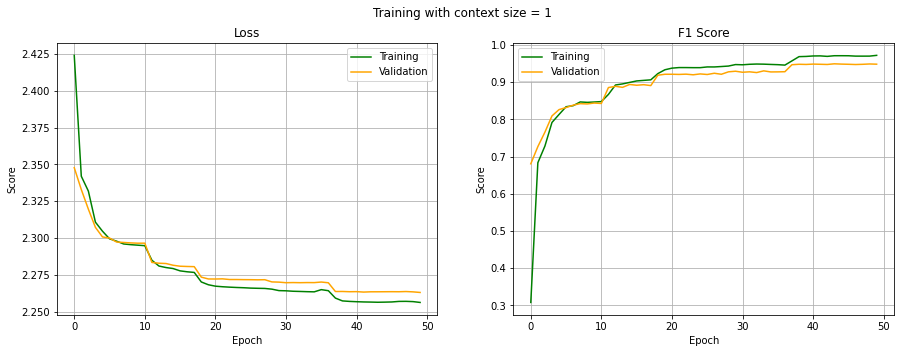

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9725, device='cuda:0'),
 tensor(0.9497, device='cuda:0'),
 tensor(0.9462, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9725, device='cuda:0'),
 tensor(0.9497, device='cuda:0'),
 tensor(0.9462, device='cuda:0'))

## Heatmap

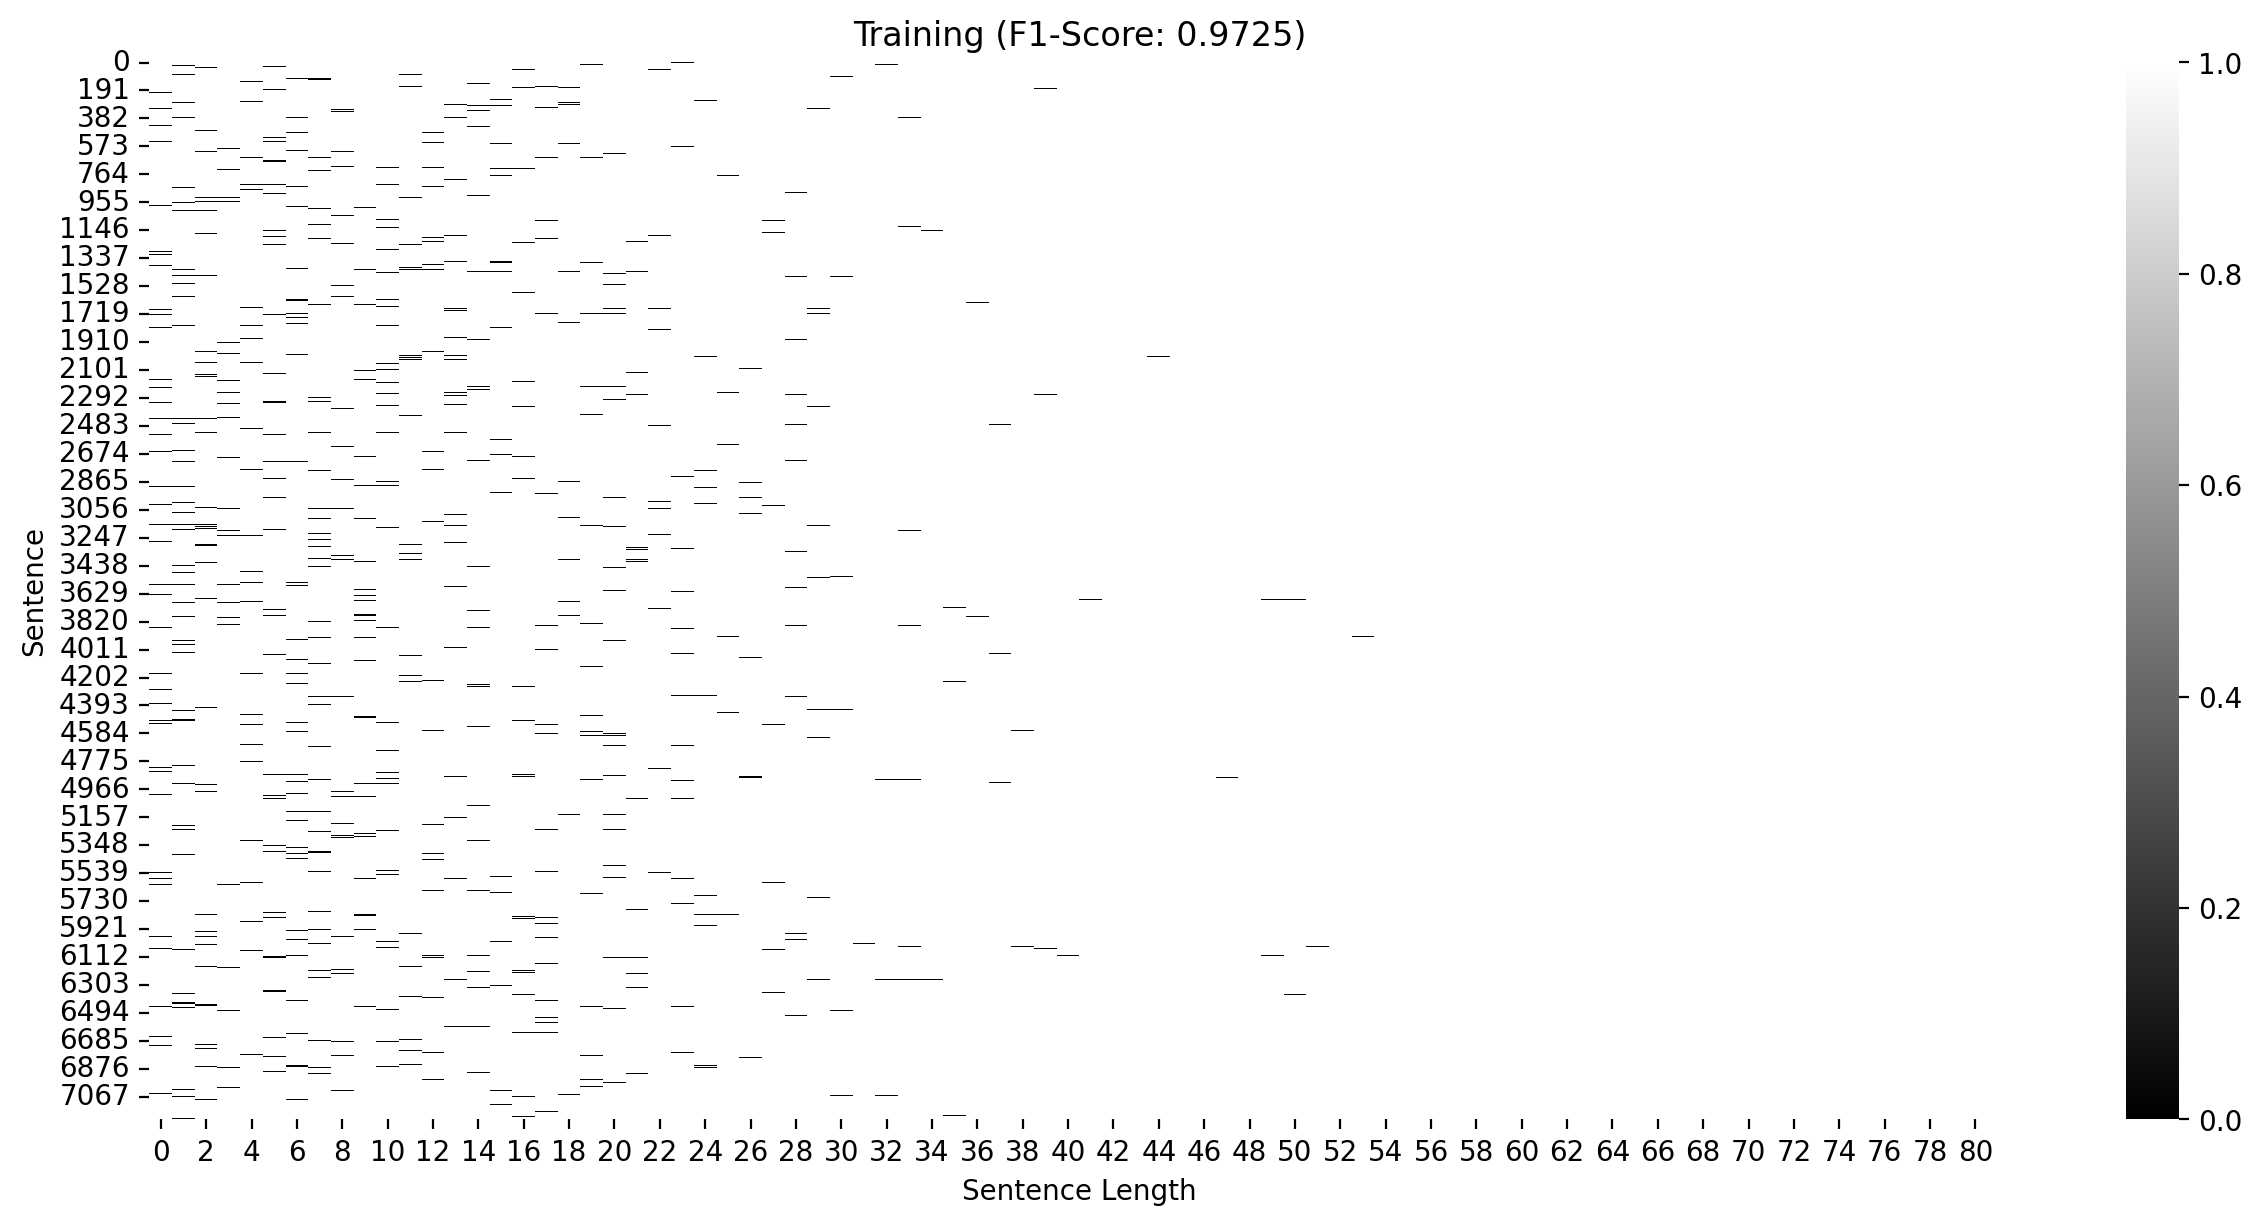

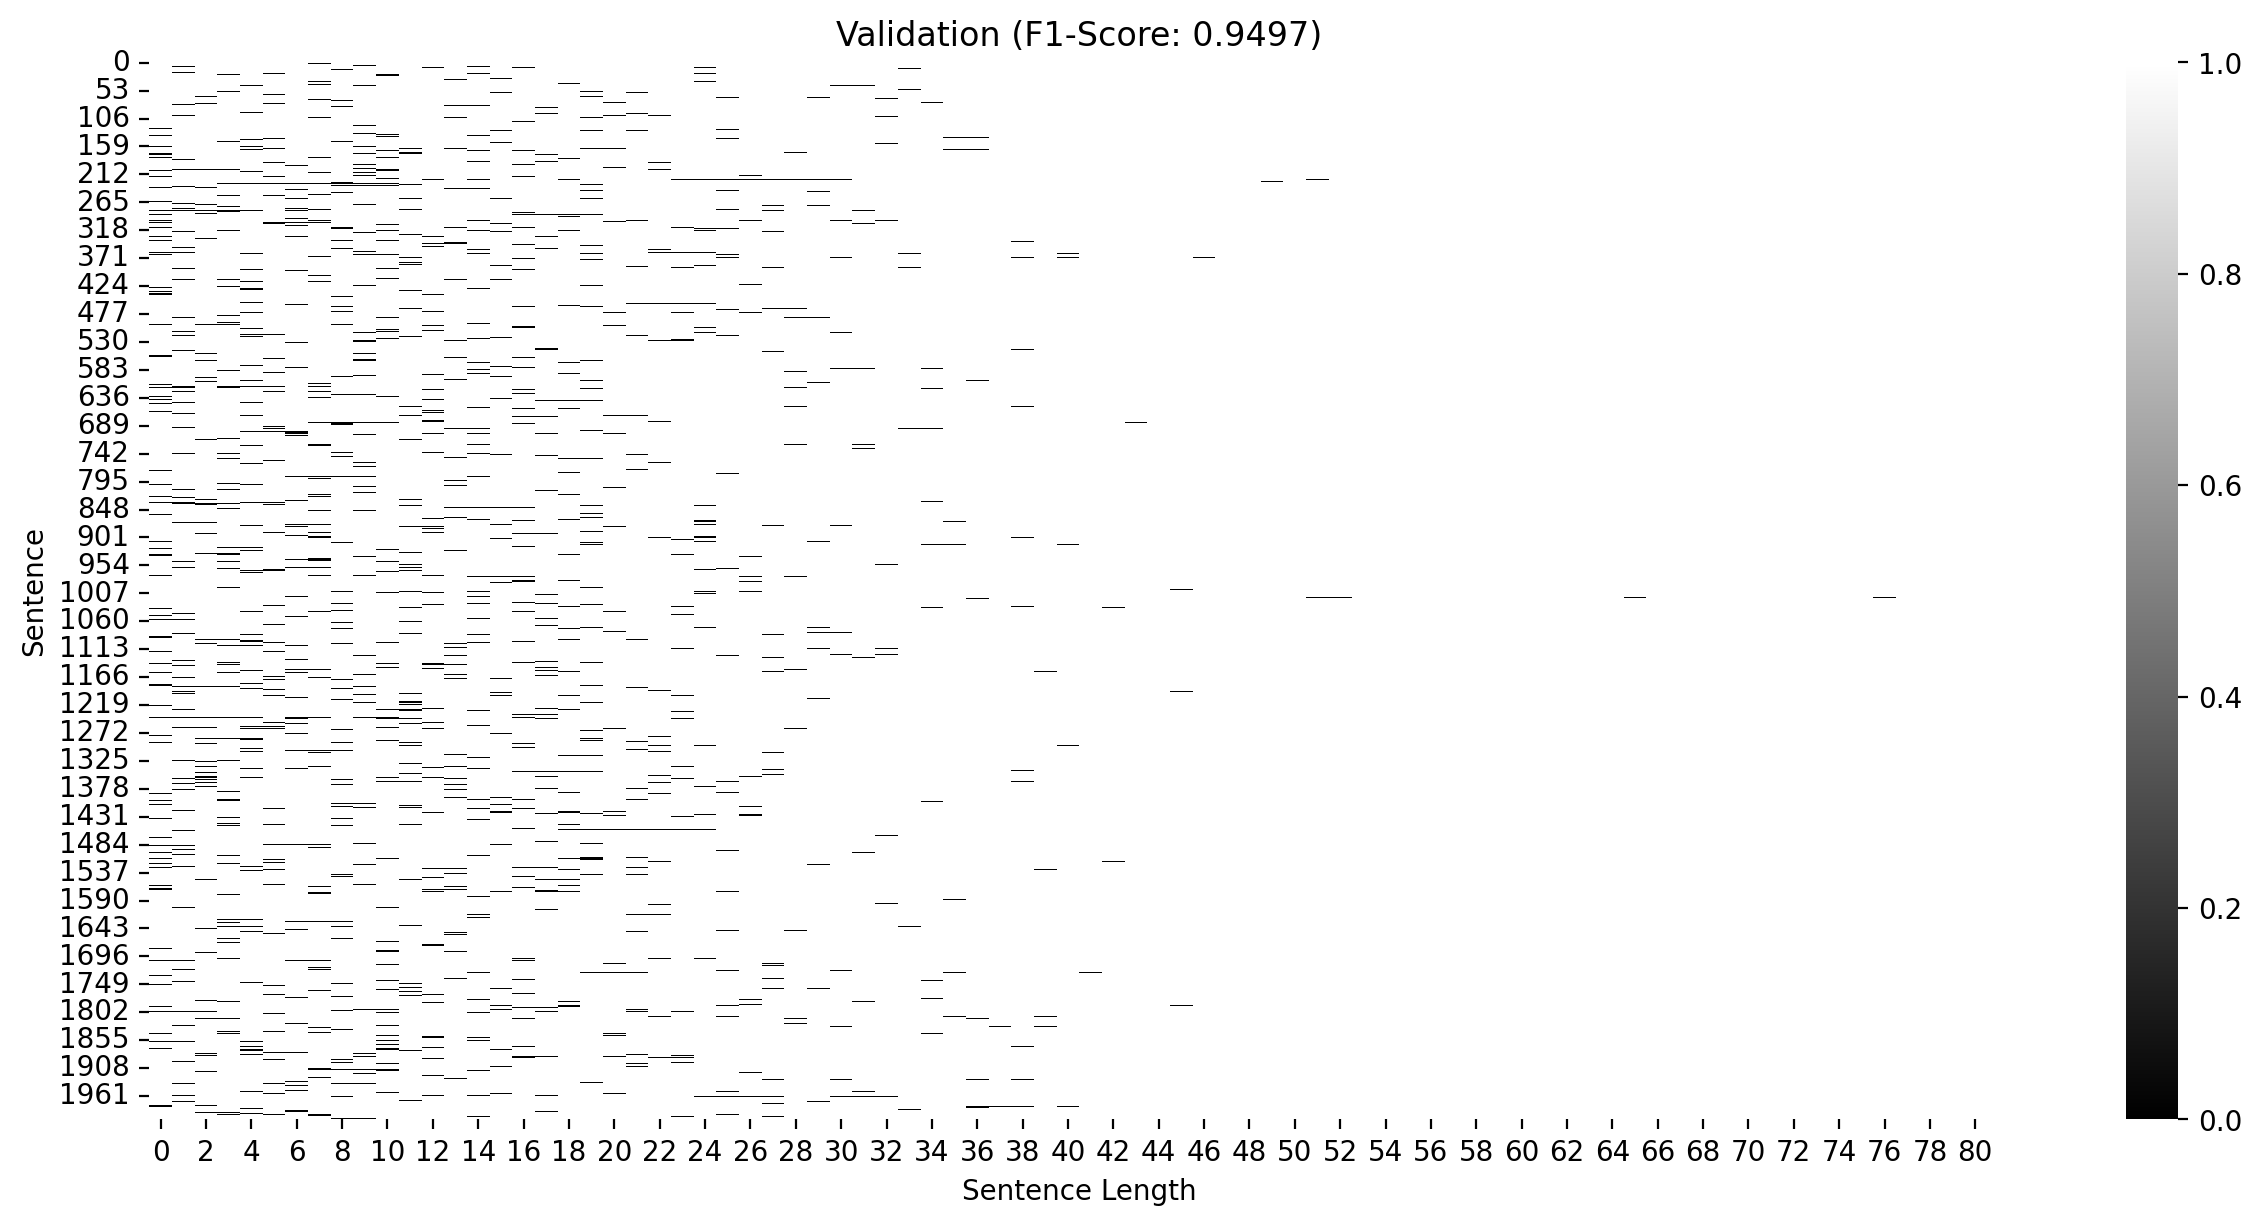

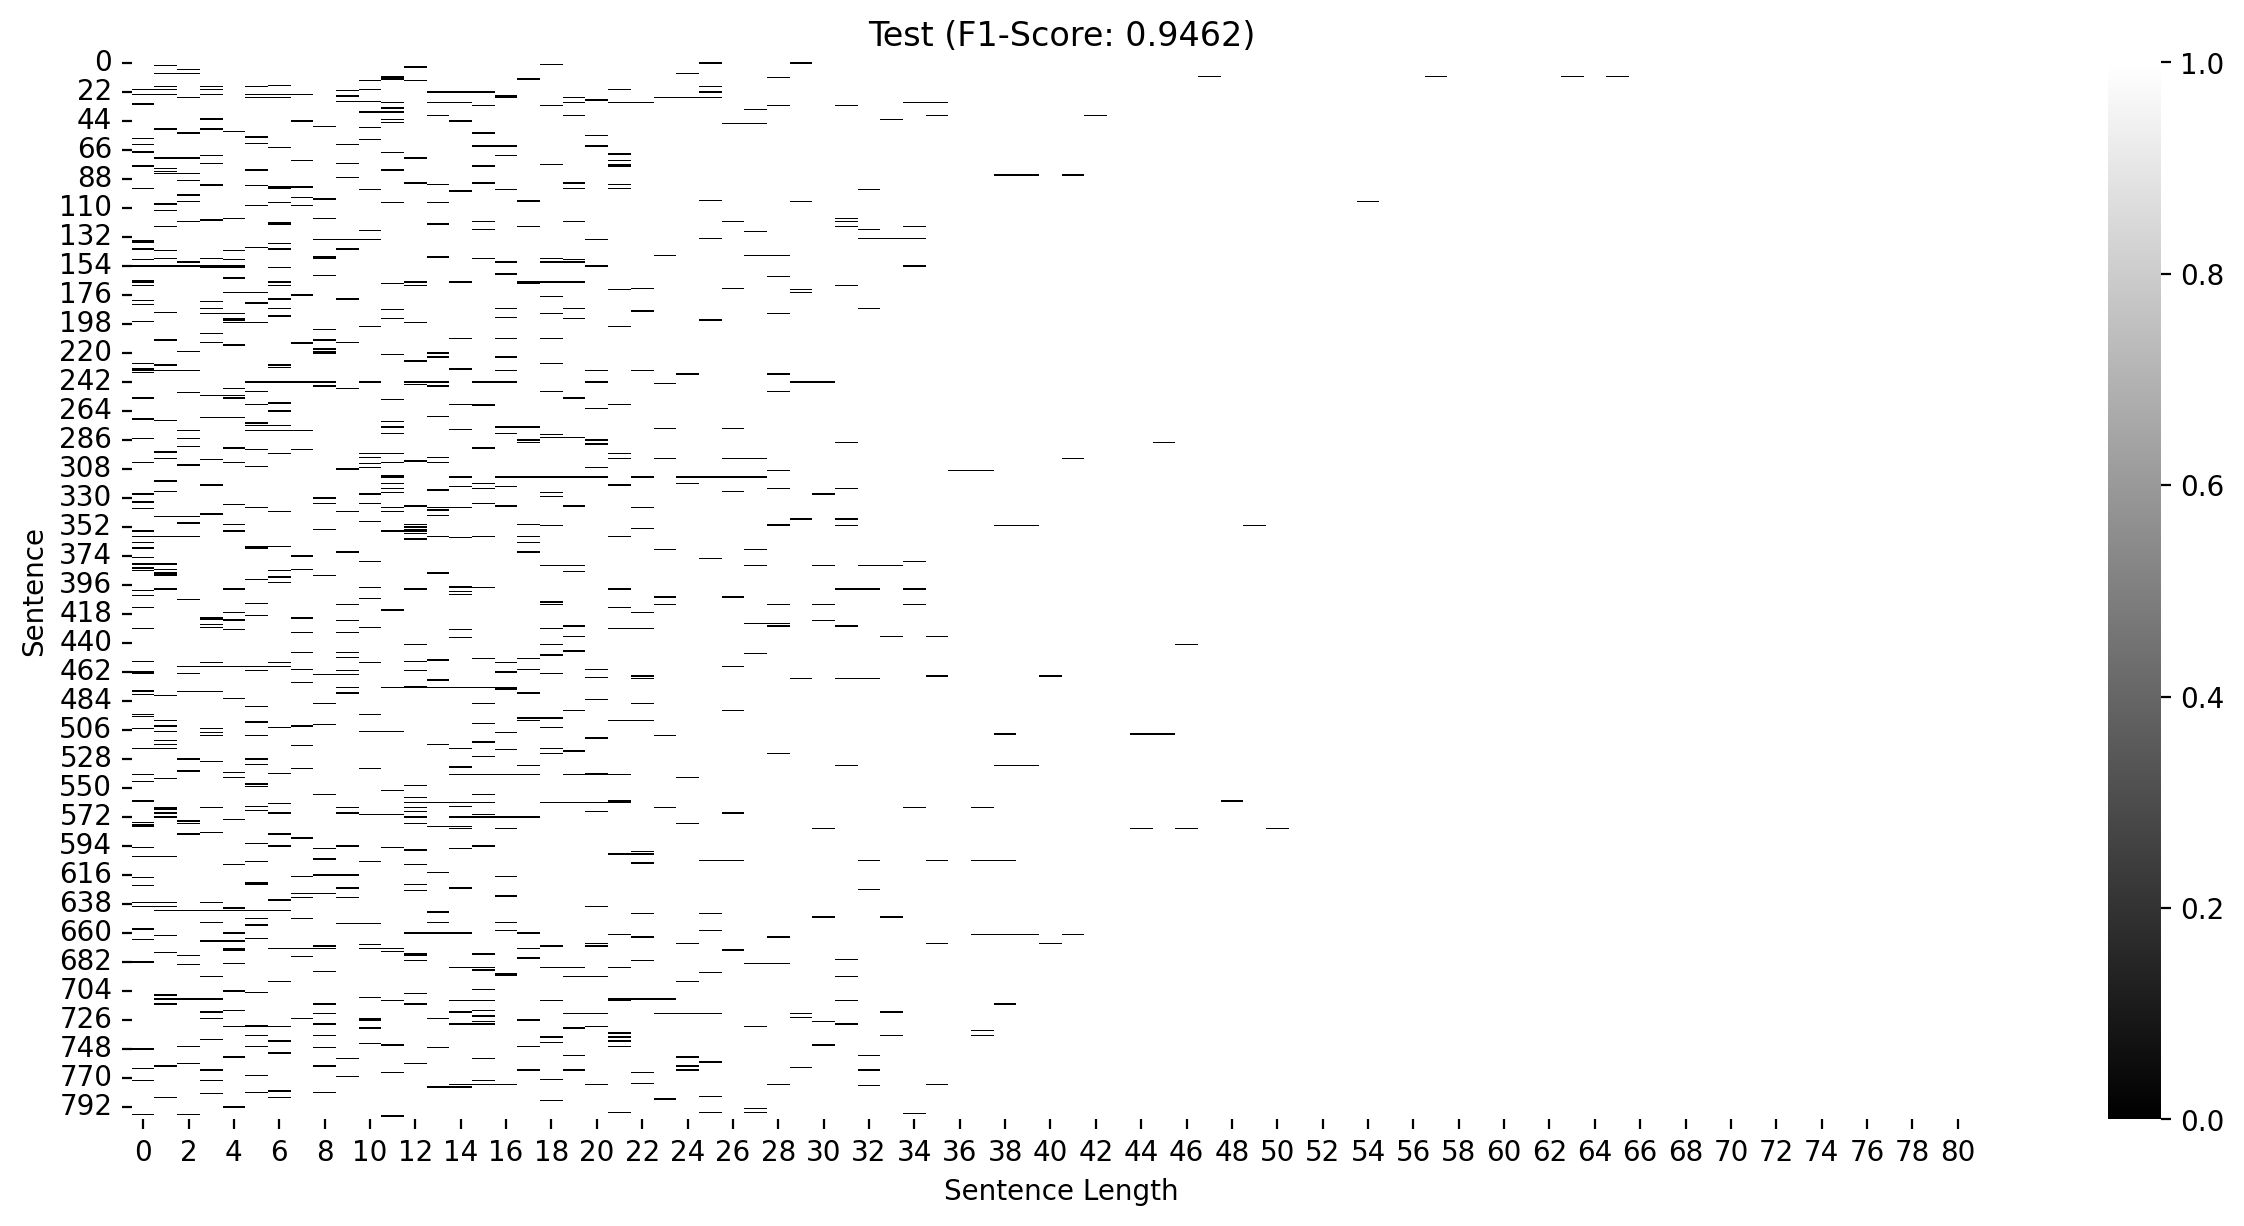

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


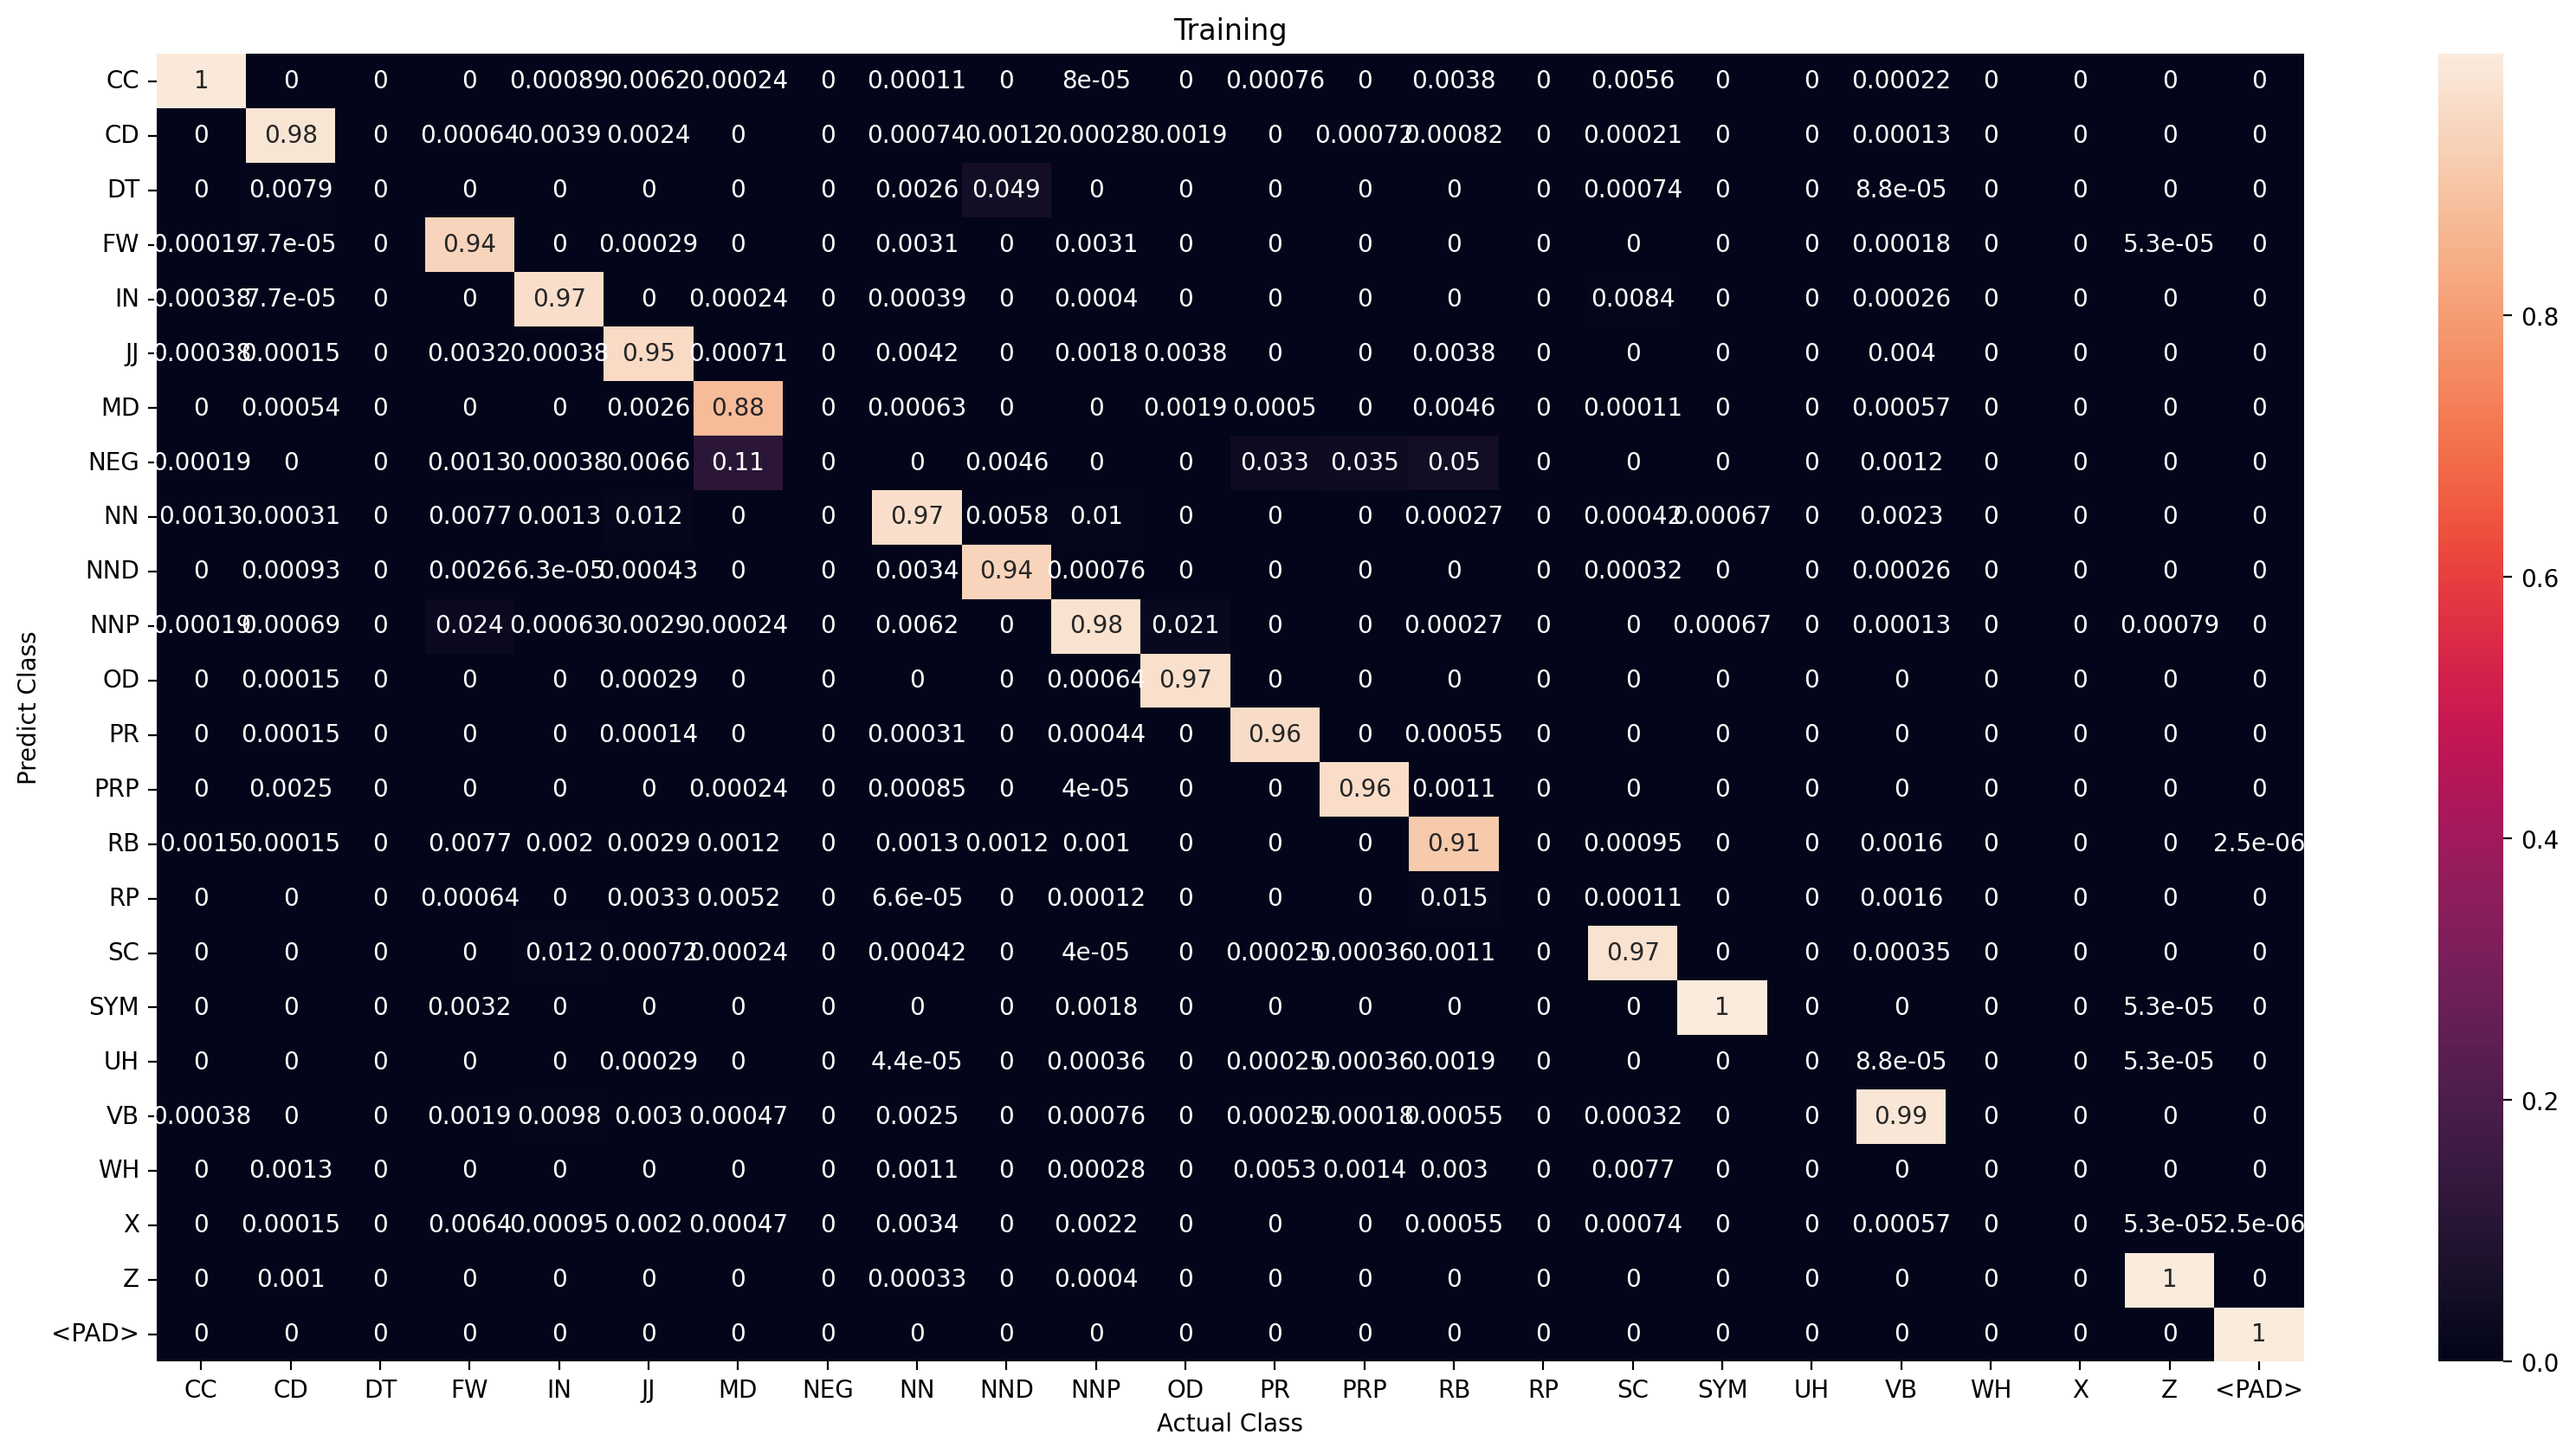

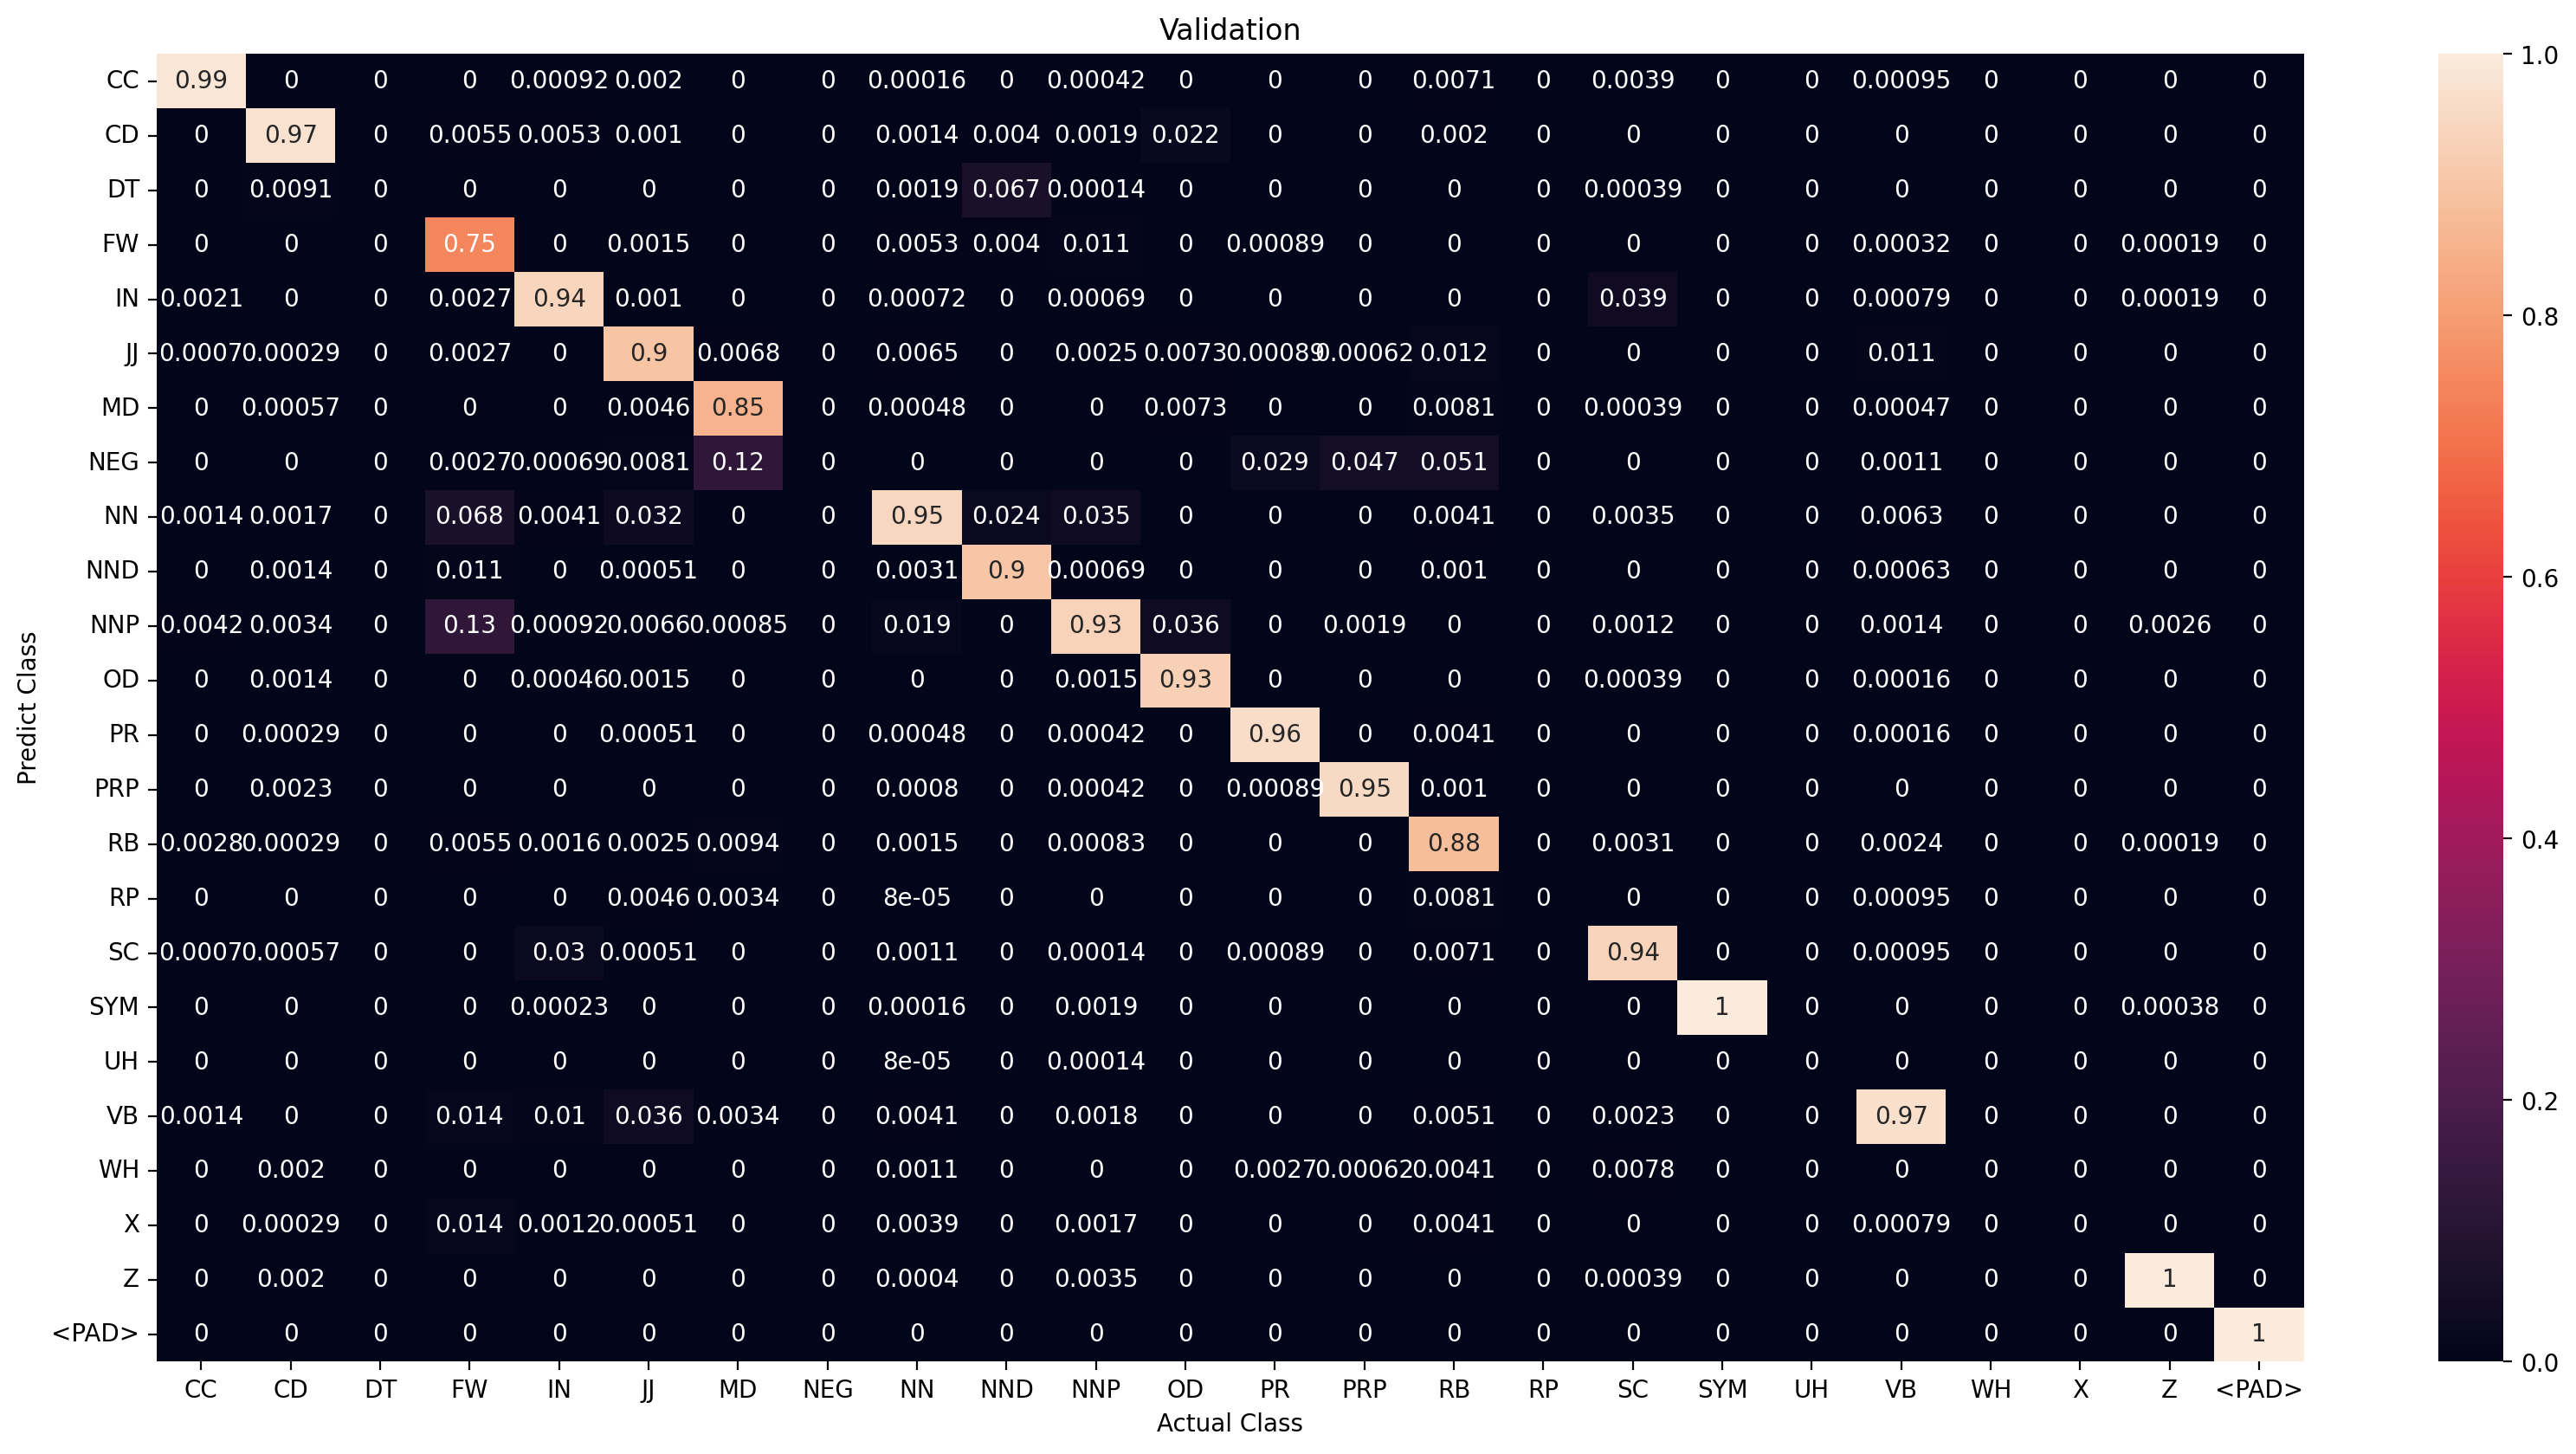

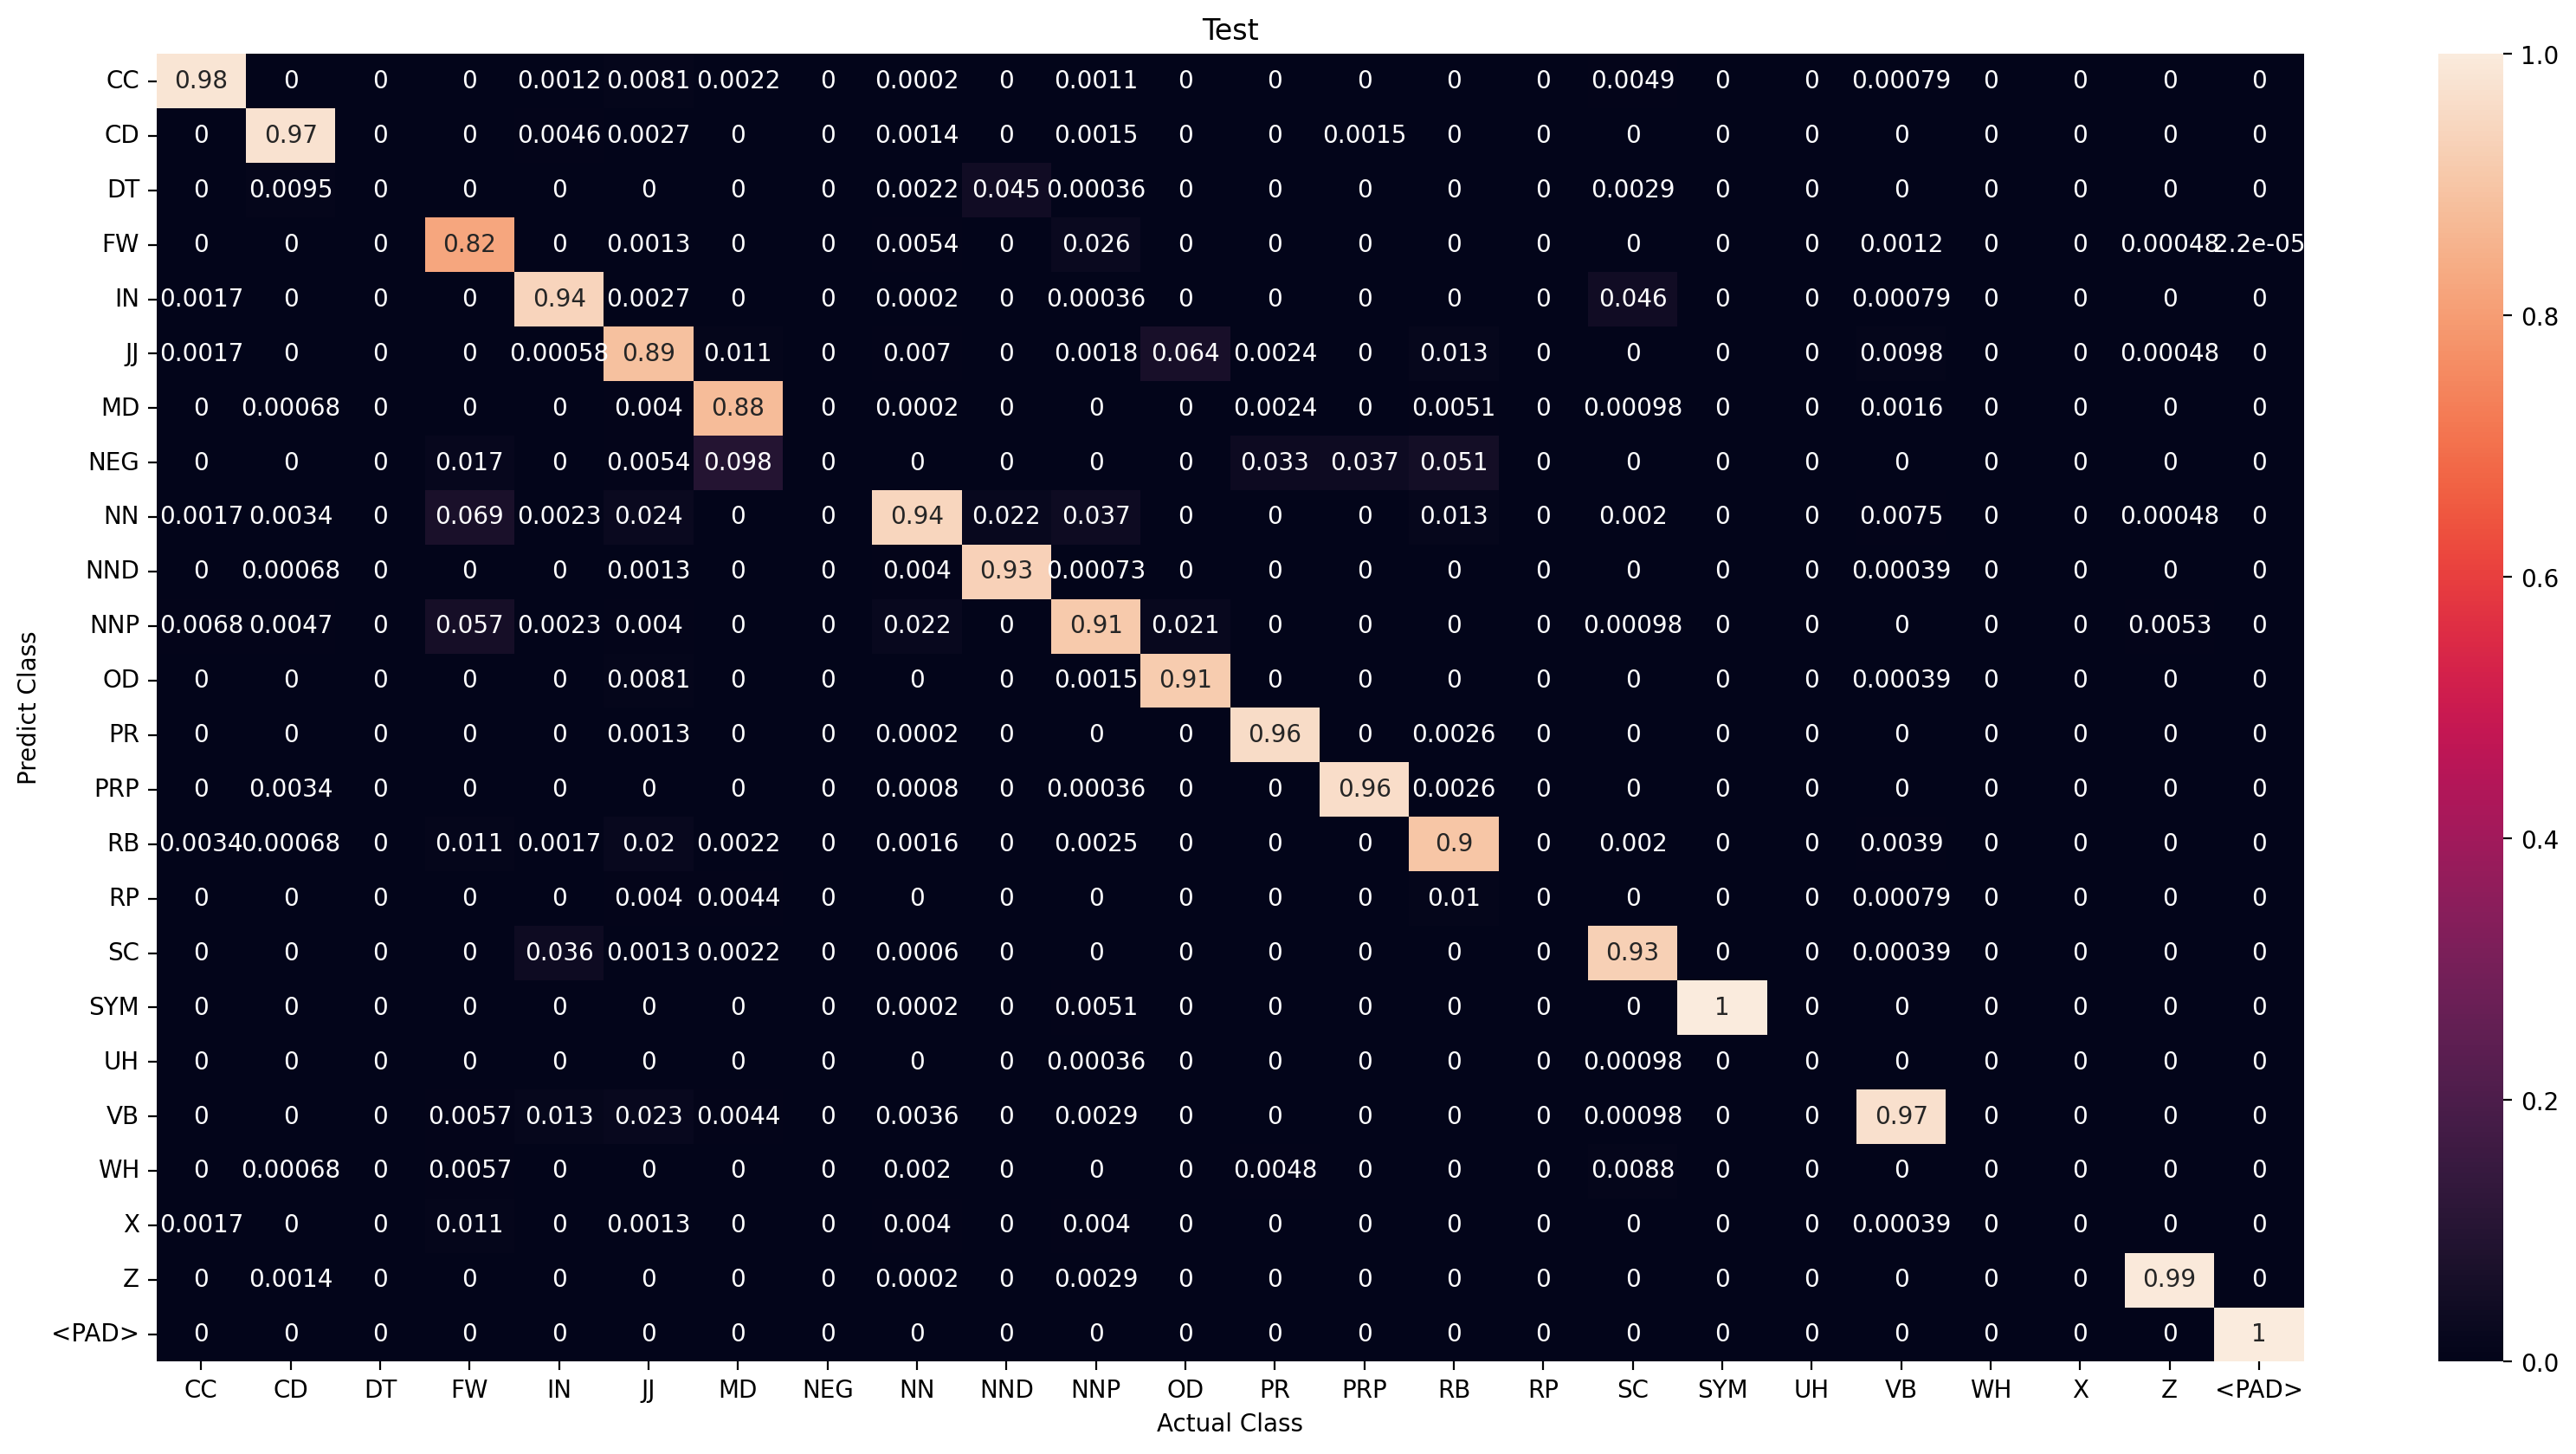

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5391   | CC    : 5251       | CC    : 140      |
| CD    : 12882  | CD    : 12747      | CD    : 135      |
| DT    : 273    | DT    : 0          | DT    : 273      |
| FW    : 1690   | FW    : 1461       | FW    : 229      |
| IN    : 15403  | IN    : 15285      | IN    : 118      |
| JJ    : 7018   | JJ    : 6655       | JJ    : 363      |
| MD    : 3810   | MD    : 3722       | MD    : 88       |
| NEG   : 1082   | NEG   : 0          | NEG   : 1082     |
| NN    : 44728  | NN    : 44274      | NN    : 454      |
| NND   : 1019   | NND   : 815        | NND   : 204      |
| NNP   : 24885  | NNP   : 24494      | NNP   : 391      |
| OD    : 534    | OD    : 514        | OD    : 20       |
| PR    : 3842   | PR    : 3812       | PR    : 30       |
| PRP   : 5405   | PRP   : 5327       | PRP   : 78       |
| RB    : 3553   | RB    : 3342       | RB    : 211      |
| RP    : 144    | RP    : 0          | RP    : 144     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11808
Correct prediction          : 11169
Wrong prediction            : 639
Percentage correct oov pred : 94.58841463414635

Validation
Number OOV token            : 3395
Correct prediction          : 3050
Wrong prediction            : 345
Percentage correct oov pred : 89.83799705449191

Test
Number OOV token            : 1359
Correct prediction          : 1220
Wrong prediction            : 139
Percentage correct oov pred : 89.77189109639441



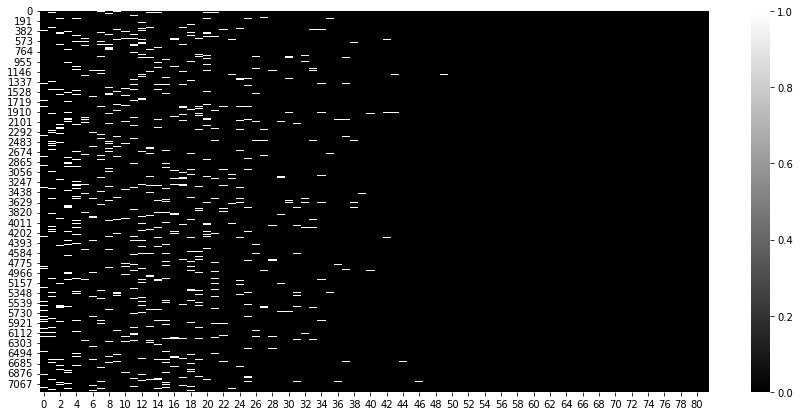

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

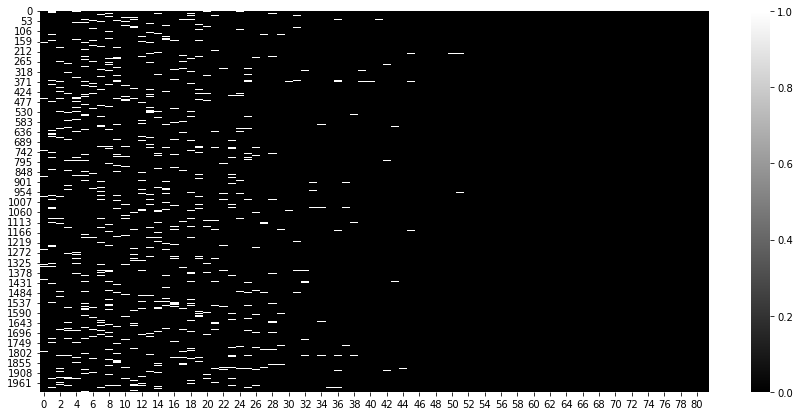

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

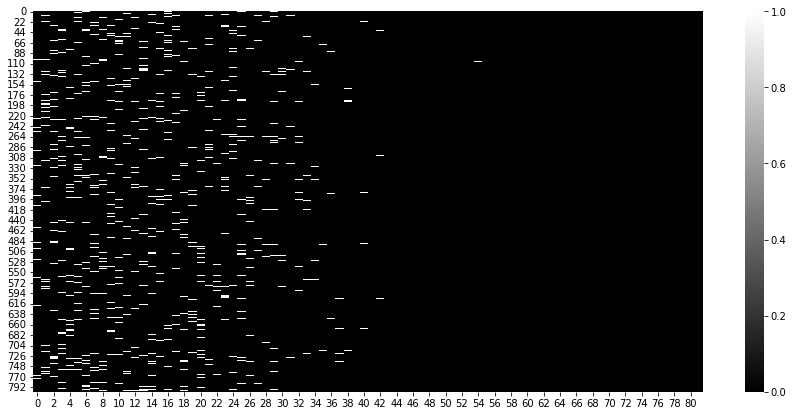

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);